# Mod 4 Project - Time Series

* Student name: THOMAS J WHIPPLE
* Student pace: part time student
* Scheduled project review date/time: FRIDAY, MAY 15, 2020, 10:00am
* Instructor name: ABHINEET KULKARNI
* Blog post URL:  https://medium.com/@mrtjwhipple/zillow-time-series-352ed141a4a


## Zillow Small Dataset Predictor

For this Flatiron Module 4 project, I will be forecasting real estate prices of various zip codes using data from the small Zillow dataset. I will be acting as a consultant for a fictional real-estate investment firm and need to build a time series model to justify my findings. The firm has asked me to determine:

> What are the top 5 best zip codes in the USA to invest?

# Import Necessary Libraries

In [1]:
# Below are the libraries I will use.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.pylab import rcParams

import itertools
from statsmodels.tsa.arima_model import ARMA
import statsmodels.api as sm

np.random.seed(123) 

# Load the Data

In [2]:
df = pd.read_csv("zillow_data.csv")
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


# Data Preprocessing

In [4]:
# Change RegionName to Zipcode
df = df.rename(columns={'RegionName': 'Zipcode'})
df.head()

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [5]:
df.SizeRank.describe()

count    14723.000000
mean      7362.000000
std       4250.308342
min          1.000000
25%       3681.500000
50%       7362.000000
75%      11042.500000
max      14723.000000
Name: SizeRank, dtype: float64

In [6]:
df.RegionID.describe()

count     14723.000000
mean      81075.010052
std       31934.118525
min       58196.000000
25%       67174.500000
50%       78007.000000
75%       90920.500000
max      753844.000000
Name: RegionID, dtype: float64

In [7]:
# Drop unnecessary columns
df = df.drop(['RegionID', 'SizeRank'], axis = 1)
df.head()

,Zipcode,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,60657,Chicago,IL,Chicago,Cook,334200.0,335400.0,336500.0,337600.0,338500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,75070,McKinney,TX,Dallas-Fort Worth,Collin,235700.0,236900.0,236700.0,235400.0,233300.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,77494,Katy,TX,Houston,Harris,210400.0,212200.0,212200.0,210700.0,208300.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,60614,Chicago,IL,Chicago,Cook,498100.0,500900.0,503100.0,504600.0,505500.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,79936,El Paso,TX,El Paso,El Paso,77300.0,77300.0,77300.0,77300.0,77400.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [8]:
df.CountyName.describe()

count           14723
unique           1212
top       Los Angeles
freq              264
Name: CountyName, dtype: object

In [9]:
df.CountyName.unique()

array(['Cook', 'Collin', 'Harris', ..., 'Sunflower', 'Jewell', 'Licking'],
      dtype=object)

In [10]:
df.Metro.describe()

count        13680
unique         701
top       New York
freq           779
Name: Metro, dtype: object

In [11]:
df.State.describe()

count     14723
unique       51
top          CA
freq       1224
Name: State, dtype: object

In [12]:
df[df.State == 'VT'].count()

Zipcode       16
City          16
State         16
Metro         16
CountyName    16
              ..
2017-12       16
2018-01       16
2018-02       16
2018-03       16
2018-04       16
Length: 270, dtype: int64

In [13]:
df[df.State == 'VT']

,Zipcode,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
6146,5641,Barre,VT,Barre,Washington,86600.0,86100.0,85700.0,85300.0,84900.0,...,168700,170100,172100,173200,172700,171400,169500,167900,166900,166200
6188,5478,Saint Albans,VT,Burlington,Franklin,102800.0,102300.0,101900.0,101400.0,101000.0,...,208700,209600,209200,208200,207400,207200,207900,208900,210300,211500
7185,5602,Montpelier,VT,Barre,Washington,98500.0,98200.0,97800.0,97500.0,97100.0,...,247400,249200,251900,254000,254700,253100,249400,246400,244900,243500
9222,5488,Swanton,VT,Burlington,Franklin,104200.0,103700.0,103200.0,102700.0,102200.0,...,193500,193600,192800,192200,192200,192600,193000,193700,194500,195300
10300,5676,Waterbury,VT,Barre,Washington,85100.0,84900.0,84800.0,84600.0,84400.0,...,253700,255700,259000,261900,262900,261300,258100,255400,253200,251300
10687,5450,Enosburg Falls,VT,Burlington,Franklin,37500.0,37400.0,37400.0,37400.0,37400.0,...,166000,166000,165500,165400,165700,166200,167000,167300,167200,167300
10897,5663,Northfield,VT,Barre,Washington,91900.0,91600.0,91300.0,90900.0,90700.0,...,172900,173600,175400,177400,178200,177400,175700,174100,173300,172900
10991,5454,Fairfax,VT,Burlington,Franklin,132900.0,132000.0,131200.0,130300.0,129300.0,...,255800,256900,256500,256100,256400,257200,258100,259300,260600,261800
11464,5673,Fayston,VT,Barre,Washington,77500.0,77200.0,76800.0,76400.0,76100.0,...,318600,320400,324700,328400,330700,330000,325700,321200,319700,318800
12383,5476,Richford,VT,Burlington,Franklin,52400.0,52000.0,51600.0,51200.0,50800.0,...,106000,105800,104300,103300,102600,101800,102300,104400,106100,107200


In [14]:
# My Vermont zip code is not in the set.
df[df.Zipcode == 5156].count()

Zipcode       0
City          0
State         0
Metro         0
CountyName    0
             ..
2017-12       0
2018-01       0
2018-02       0
2018-03       0
2018-04       0
Length: 270, dtype: int64

# EDA

As many New Yorkers and Bostonians may be thinking about moving out of the city over the next few years I have decided to focus on small villages in the Northeast. My business plan involves determining the New England zip code that will bring the highest return over the next few years as potential investments as well as places to move. A village will be considered any town that is between 10,000 and 15,000 people as we hope to find small, quaint centers that aren't suburbs of large metro areas but still have some commerce. For sake of diversity, we will narrow the field down to the top two zip codes in each of the six New England states.

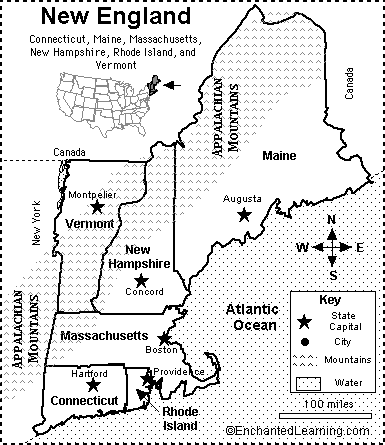

In [15]:
# I viewed this map of the New England states.
from IPython.display import Image 
Image("../time-series/new_england.gif")

## Filtering for Chosen Zipcodes 
I need to narrow down my 14,723 zipcodes...

### New England zip codes

In [16]:
# New England zipcodes all begin with zero and therefore have only four digits
NE_zips = df.loc[df['Zipcode'] < 9999]
NE_zips.head()

,Zipcode,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
57,7030,Hoboken,NJ,New York,Hudson,301600.0,302700.0,303800.0,304800.0,305800.0,...,1789100,1803000,1818100,1836900,1850100,1853500,1852200,1854400,1857600,1854300
73,8701,Lakewood,NJ,New York,Ocean,153800.0,153400.0,153000.0,152500.0,152200.0,...,400500,403900,408400,411000,412600,414000,415700,415600,413400,410700
88,2169,Quincy,MA,Boston,Norfolk,137800.0,137900.0,137900.0,138000.0,138100.0,...,416900,417800,421100,425100,428600,431900,435700,440500,445800,449100
112,6010,Bristol,CT,Hartford,Hartford,120300.0,120000.0,119800.0,119400.0,119100.0,...,188900,190000,191200,191800,192900,193600,194100,194900,195700,195700
149,2148,Malden,MA,Boston,Middlesex,130600.0,130700.0,130800.0,131000.0,131200.0,...,439100,442400,446700,451400,454700,457700,461900,466000,469300,471100


In [17]:
# Down to about 10% of the data
NE_zips.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1403 entries, 57 to 14719
Columns: 270 entries, Zipcode to 2018-04
dtypes: float64(219), int64(47), object(4)
memory usage: 2.9+ MB


In [18]:
# There should be six New England states!
NE_zips.State.unique()

array(['NJ', 'MA', 'CT', 'ME', 'RI', 'NH', 'VT'], dtype=object)

In [19]:
# I viewed this map of the New England states.
from IPython.display import Image
from IPython.core.display import HTML 
basin_url = ("https://newengland.com/wp-content/uploads/new-england-states-map.jpg")
Image(url=basin_url, width=500, height=400)

In [20]:
# Whooops, New Jersey is not a part of New England!
NE_zips.drop(NE_zips[NE_zips['State'] == 'NJ'].index, inplace=True) 

/Users/whipxach/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [21]:
# The five New England states: 'MA', 'CT', 'ME', 'RI', 'NH', 'VT'
NE_zips.State.unique()

array(['MA', 'CT', 'ME', 'RI', 'NH', 'VT'], dtype=object)

In [22]:
# Still have a long way to go
NE_zips.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 901 entries, 88 to 14719
Columns: 270 entries, Zipcode to 2018-04
dtypes: float64(219), int64(47), object(4)
memory usage: 1.9+ MB


In [23]:
# This seems correct
NE_zips.Zipcode.max()

6897

### Population and zipcodes

Again, in order to stick to the business plan, we will be cross referencing only the zip codes for villages between 10 and 15 thousand people - below that may be too small, too touristy, or may not have enough of a town center to provide adequate opportunities for necessities such as restaurants, groceries, or gas. Towns larger than that won't have the quaint New England feel, too near a large metro area, or may be a suburb.

In [24]:
# Population by state database 
# From "The US Decennial Census of Population and Housing"
population = pd.read_csv('population_by_zip_2010.csv')
population.head()

,population,minimum_age,maximum_age,gender,zipcode,geo_id
0,50,30.0,34.0,female,61747,8600000US61747
1,5,85.0,NaN,male,64120,8600000US64120
2,1389,30.0,34.0,male,95117,8600000US95117
3,231,60.0,61.0,female,74074,8600000US74074
4,56,0.0,4.0,female,58042,8600000US58042


In [25]:
# Looks pretty straight forward...
population.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1622831 entries, 0 to 1622830
Data columns (total 6 columns):
population     1622831 non-null int64
minimum_age    1523474 non-null float64
maximum_age    1457236 non-null float64
gender         1589712 non-null object
zipcode        1622831 non-null int64
geo_id         1622831 non-null object
dtypes: float64(2), int64(2), object(2)
memory usage: 74.3+ MB


In [26]:
# But when I check out my zip code this dataframe is really confusing
population[population.zipcode == 5156].head(10)

,population,minimum_age,maximum_age,gender,zipcode,geo_id
18952,9226,NaN,NaN,NaN,5156,8600000US05156
28666,129,67.0,69.0,female,5156,8600000US05156
60305,99,18.0,19.0,male,5156,8600000US05156
85810,136,75.0,79.0,female,5156,8600000US05156
95394,161,70.0,74.0,male,5156,8600000US05156
118648,270,10.0,14.0,female,5156,8600000US05156
152606,91,85.0,NaN,male,5156,8600000US05156
174155,392,45.0,49.0,male,5156,8600000US05156
443238,258,5.0,9.0,female,5156,8600000US05156
446662,41,20.0,20.0,male,5156,8600000US05156


In [27]:
# I need to sort out only the totals, which are integrated into the columns
totals = population[(population['minimum_age'].isnull()) & 
                    (population['maximum_age'].isnull()) & 
                    (population['gender'].isnull())]

In [28]:
# Looks like that worked
totals.head()

,population,minimum_age,maximum_age,gender,zipcode,geo_id
36,27669,NaN,NaN,NaN,91324,8600000US91324
116,4449,NaN,NaN,NaN,72632,8600000US72632
127,473,NaN,NaN,NaN,72739,8600000US72739
135,1685,NaN,NaN,NaN,27305,8600000US27305
178,24425,NaN,NaN,NaN,1843,8600000US01843


In [29]:
# This looks more like the correct numbers!
totals[totals.zipcode == 5156]

,population,minimum_age,maximum_age,gender,zipcode,geo_id
18952,9226,NaN,NaN,NaN,5156,8600000US05156


In [30]:
# Simplify new dataframe to get rid of everything else
totals = totals[['population', 'zipcode']]
totals.head()

,population,zipcode
36,27669,91324
116,4449,72632
127,473,72739
135,1685,27305
178,24425,1843


In [31]:
# Reduce it down to just New England again
totals = totals.loc[(totals['zipcode'] < 6999) & (totals['zipcode'] > 999)]
totals.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1832 entries, 178 to 1621371
Data columns (total 2 columns):
population    1832 non-null int64
zipcode       1832 non-null int64
dtypes: int64(2)
memory usage: 42.9 KB


In [32]:
# Looks like it's still going to be bigger than my original dataset
totals.describe()

,population,zipcode
count,1832.000000,1832.000000
mean,7884.877183,3958.088974
std,10428.089613,1682.834151
min,0.000000,1001.000000
25%,1061.500000,2563.750000
50%,3234.000000,4070.000000
75%,10556.500000,5350.500000
max,63406.000000,6907.000000


In [33]:
# Merge the lat and lon with my first NE dataframe
ne_pops = NE_zips.merge(totals, left_on='Zipcode', right_on='zipcode')
ne_pops.head()

,Zipcode,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,population,zipcode
0,2169,Quincy,MA,Boston,Norfolk,137800.0,137900.0,137900.0,138000.0,138100.0,...,421100,425100,428600,431900,435700,440500,445800,449100,55055,2169
1,6010,Bristol,CT,Hartford,Hartford,120300.0,120000.0,119800.0,119400.0,119100.0,...,191200,191800,192900,193600,194100,194900,195700,195700,60448,6010
2,2148,Malden,MA,Boston,Middlesex,130600.0,130700.0,130800.0,131000.0,131200.0,...,446700,451400,454700,457700,461900,466000,469300,471100,59503,2148
3,2155,Medford,MA,Boston,Middlesex,157100.0,157300.0,157500.0,157800.0,158100.0,...,576400,582800,588600,594700,602100,609000,613300,614800,57964,2155
4,2360,Plymouth,MA,Boston,Plymouth,125900.0,126200.0,126500.0,126700.0,126800.0,...,344900,347200,349000,351300,354400,356800,358300,358400,56271,2360


In [34]:
# Get rid of the second zipcode (not sure how to do this in 'merge')
ne_pops.drop('zipcode', axis=1, inplace=True)
ne_pops.head()

,Zipcode,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,population
0,2169,Quincy,MA,Boston,Norfolk,137800.0,137900.0,137900.0,138000.0,138100.0,...,417800,421100,425100,428600,431900,435700,440500,445800,449100,55055
1,6010,Bristol,CT,Hartford,Hartford,120300.0,120000.0,119800.0,119400.0,119100.0,...,190000,191200,191800,192900,193600,194100,194900,195700,195700,60448
2,2148,Malden,MA,Boston,Middlesex,130600.0,130700.0,130800.0,131000.0,131200.0,...,442400,446700,451400,454700,457700,461900,466000,469300,471100,59503
3,2155,Medford,MA,Boston,Middlesex,157100.0,157300.0,157500.0,157800.0,158100.0,...,570100,576400,582800,588600,594700,602100,609000,613300,614800,57964
4,2360,Plymouth,MA,Boston,Plymouth,125900.0,126200.0,126500.0,126700.0,126800.0,...,341700,344900,347200,349000,351300,354400,356800,358300,358400,56271


In [35]:
# Still at 901 zipcodes in New England
ne_pops.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 901 entries, 0 to 900
Columns: 271 entries, Zipcode to population
dtypes: float64(219), int64(48), object(4)
memory usage: 1.9+ MB


In [36]:
# Look at the demographics
ne_pops.population.describe()

count      901.000000
mean     12392.804661
std      11700.762013
min        143.000000
25%       3297.000000
50%       8088.000000
75%      17700.000000
max      61025.000000
Name: population, dtype: float64

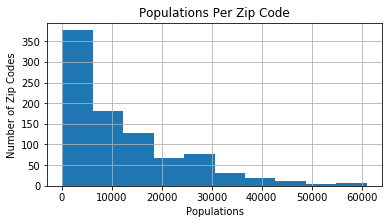

In [253]:
# Turns out that the average population in the dataset is less than 10,000
ne_pops.population.hist(figsize=(6,3))
plt.title('Populations Per Zip Code')
plt.xlabel('Populations')
plt.ylabel('Number of Zip Codes')
plt.show()

In [38]:
# I just have to check my homestate of Vermont
ne_pops.loc[(ne_pops['State'] == 'VT')]

,Zipcode,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,population
249,5641,Barre,VT,Barre,Washington,86600.0,86100.0,85700.0,85300.0,84900.0,...,170100,172100,173200,172700,171400,169500,167900,166900,166200,17169
256,5478,Saint Albans,VT,Burlington,Franklin,102800.0,102300.0,101900.0,101400.0,101000.0,...,209600,209200,208200,207400,207200,207900,208900,210300,211500,14449
318,5602,Montpelier,VT,Barre,Washington,98500.0,98200.0,97800.0,97500.0,97100.0,...,249200,251900,254000,254700,253100,249400,246400,244900,243500,11916
466,5488,Swanton,VT,Burlington,Franklin,104200.0,103700.0,103200.0,102700.0,102200.0,...,193600,192800,192200,192200,192600,193000,193700,194500,195300,7690
557,5676,Waterbury,VT,Barre,Washington,85100.0,84900.0,84800.0,84600.0,84400.0,...,255700,259000,261900,262900,261300,258100,255400,253200,251300,4984
591,5450,Enosburg Falls,VT,Burlington,Franklin,37500.0,37400.0,37400.0,37400.0,37400.0,...,166000,165500,165400,165700,166200,167000,167300,167200,167300,4977
608,5663,Northfield,VT,Barre,Washington,91900.0,91600.0,91300.0,90900.0,90700.0,...,173600,175400,177400,178200,177400,175700,174100,173300,172900,6773
615,5454,Fairfax,VT,Burlington,Franklin,132900.0,132000.0,131200.0,130300.0,129300.0,...,256900,256500,256100,256400,257200,258100,259300,260600,261800,4447
646,5673,Fayston,VT,Barre,Washington,77500.0,77200.0,76800.0,76400.0,76100.0,...,320400,324700,328400,330700,330000,325700,321200,319700,318800,2574
709,5476,Richford,VT,Burlington,Franklin,52400.0,52000.0,51600.0,51200.0,50800.0,...,105800,104300,103300,102600,101800,102300,104400,106100,107200,3183


In [39]:
# Towns less than 3000 people
ne_rural = ne_pops.loc[(ne_pops['population'] < 3000)]
ne_rural.head()                       

,Zipcode,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,population
427,2657,Provincetown,MA,Cape Cod,Barnstable,149800.0,151800.0,153700.0,155800.0,157900.0,...,834100,842000,854200,867800,874700,872000,890200,925300,946200,2942
575,2639,Dennis,MA,Cape Cod,Barnstable,100100.0,100000.0,100000.0,99900.0,99800.0,...,315400,316800,317700,318800,319200,318900,319900,322400,324000,2875
594,2667,Wellfleet,MA,Cape Cod,Barnstable,164500.0,163500.0,162500.0,161400.0,160400.0,...,545100,547700,547800,549800,551800,552400,555900,561200,563000,2580
646,5673,Fayston,VT,Barre,Washington,77500.0,77200.0,76800.0,76400.0,76100.0,...,320400,324700,328400,330700,330000,325700,321200,319700,318800,2574
659,3753,Grantham,NH,Claremont,Sullivan,146300.0,145300.0,144400.0,143500.0,142700.0,...,260100,261300,261900,262300,262900,263100,262800,262700,262600,2971


In [40]:
ne_rural.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199 entries, 427 to 900
Columns: 271 entries, Zipcode to population
dtypes: float64(219), int64(48), object(4)
memory usage: 422.9+ KB


In [41]:
ne_rural.State.value_counts()

NH    86
MA    61
CT    20
ME    19
VT     7
RI     6
Name: State, dtype: int64

In [42]:
# Towns more than 50000 people
ne_towns = ne_pops.loc[(ne_pops['population'] > 47000)]
ne_towns.head()      

,Zipcode,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,population
0,2169,Quincy,MA,Boston,Norfolk,137800.0,137900.0,137900.0,138000.0,138100.0,...,417800,421100,425100,428600,431900,435700,440500,445800,449100,55055
1,6010,Bristol,CT,Hartford,Hartford,120300.0,120000.0,119800.0,119400.0,119100.0,...,190000,191200,191800,192900,193600,194100,194900,195700,195700,60448
2,2148,Malden,MA,Boston,Middlesex,130600.0,130700.0,130800.0,131000.0,131200.0,...,442400,446700,451400,454700,457700,461900,466000,469300,471100,59503
3,2155,Medford,MA,Boston,Middlesex,157100.0,157300.0,157500.0,157800.0,158100.0,...,570100,576400,582800,588600,594700,602100,609000,613300,614800,57964
4,2360,Plymouth,MA,Boston,Plymouth,125900.0,126200.0,126500.0,126700.0,126800.0,...,341700,344900,347200,349000,351300,354400,356800,358300,358400,56271


In [43]:
ne_towns.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15 entries, 0 to 58
Columns: 271 entries, Zipcode to population
dtypes: float64(219), int64(48), object(4)
memory usage: 31.9+ KB


In [44]:
ne_towns.State.value_counts()

MA    11
CT     4
Name: State, dtype: int64

In [45]:
# Villages around 12,000 people
ne_villages = ne_pops.loc[(ne_pops['population'] > 10000) & (ne_pops['population'] < 16000)]
ne_villages.head() 

,Zipcode,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,population
198,2649,Mashpee,MA,Cape Cod,Barnstable,133000.0,132900.0,132700.0,132400.0,132100.0,...,401100,404500,407100,410900,414000,415100,417600,422400,425600,14006
203,3246,Laconia,NH,Laconia,Belknap,84800.0,84300.0,83900.0,83500.0,83200.0,...,179500,180700,182100,183800,185900,187800,189600,192000,194300,15963
217,2882,Narragansett,RI,Providence,Washington,145000.0,144700.0,144400.0,144100.0,143800.0,...,429900,430300,431400,433000,434500,435400,437100,442200,447900,14184
218,3842,Hampton,NH,Boston,Rockingham,135400.0,135600.0,135900.0,136300.0,136800.0,...,379500,382000,384700,387100,389100,390600,391800,394600,398100,15345
220,2601,Barnstable,MA,Cape Cod,Barnstable,95000.0,94800.0,94600.0,94400.0,94200.0,...,278100,280600,282700,285300,287700,289200,292900,299800,305300,14089


In [46]:
ne_villages.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128 entries, 198 to 475
Columns: 271 entries, Zipcode to population
dtypes: float64(219), int64(48), object(4)
memory usage: 272.0+ KB


In [47]:
ne_villages.State.value_counts()

MA    78
CT    19
NH    18
RI     7
ME     4
VT     2
Name: State, dtype: int64

In [48]:
# Thin out Mass
ne_villages.drop(ne_villages[(ne_villages.State == "MA") & 
                             (ne_villages.population > 14000)].index,
                 inplace=True)
ne_villages.State.value_counts()

MA    51
CT    19
NH    18
RI     7
ME     4
VT     2
Name: State, dtype: int64

In [49]:
# No Boston Suburbs!
ne_villages.drop(ne_villages[ne_villages.Metro == "Boston"].index, inplace=True)

In [50]:
# No Fall River!
ne_villages.drop(ne_villages[ne_villages.CountyName == "Bristol"].index, inplace=True)

In [51]:
# No Cape Cod!
ne_villages.drop(ne_villages[ne_villages.Metro == "Cape Cod"].index, inplace=True)

In [52]:
# No Springfield!
ne_villages.drop(ne_villages[ne_villages.City == "Springfield"].index, inplace=True)

In [53]:
# No Worcester Suburbs!
ne_villages.drop(ne_villages[ne_villages.CountyName == "Worcester"].index, inplace=True)

In [54]:
# Get down to two
ne_villages.drop(ne_villages[ne_villages.City == "Agawam"].index, inplace=True)

In [55]:
ne_villages.loc[(ne_villages['State'] == 'MA')]

,Zipcode,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,population
365,1062,Northampton,MA,Springfield,Hampshire,127000.0,126200.0,125300.0,124400.0,123500.0,...,274600,276700,278800,280900,282800,284600,285200,282600,279500,11150
371,1082,Ware,MA,Springfield,Hampshire,105300.0,104800.0,104100.0,103500.0,103000.0,...,174600,175400,176500,178000,179400,181100,182500,183300,183800,10322


In [56]:
ne_villages.State.value_counts()

CT    19
NH    13
RI     6
ME     4
VT     2
MA     2
Name: State, dtype: int64

In [57]:
# Thin out Connetticut zips
ne_villages.loc[(ne_villages['State'] == 'CT')]

,Zipcode,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,population
263,6517,Hamden,CT,New Haven,New Haven,119900.0,119800.0,119600.0,119500.0,119500.0,...,224000,227200,229600,230900,231400,232100,231700,228600,225200,14853
292,6355,Groton,CT,New London,New London,136700.0,136900.0,137000.0,137100.0,137300.0,...,270900,269300,268200,268000,268800,270000,271800,273600,274200,12985
305,6416,Cromwell,CT,Hartford,Middlesex,145800.0,145400.0,145100.0,144700.0,144200.0,...,250500,253300,255800,258100,259900,261100,261000,259300,258000,14005
306,6357,Niantic,CT,New London,New London,123600.0,123800.0,123900.0,123900.0,123900.0,...,274400,276800,277800,277500,277300,278300,279500,279800,278800,12552
313,6461,Milford,CT,New Haven,New Haven,161400.0,161000.0,160700.0,160400.0,160200.0,...,308800,308900,308700,309200,310400,311700,313700,315700,316500,14552
326,6795,Watertown,CT,Torrington,Litchfield,149300.0,148900.0,148700.0,148500.0,148400.0,...,248800,249900,250800,252500,253600,253400,251100,248900,247800,14144
329,6706,Waterbury,CT,New Haven,New Haven,80800.0,80600.0,80400.0,80200.0,80000.0,...,102700,103600,105100,107200,108900,109800,109500,109000,108600,14324
334,6477,Orange,CT,New Haven,New Haven,205900.0,205400.0,204900.0,204400.0,204100.0,...,348200,348400,349400,350300,351500,352900,354500,355600,355600,13956
339,6076,Stafford Springs,CT,Hartford,Tolland,117200.0,116700.0,116100.0,115500.0,114900.0,...,196000,195300,193900,192000,190800,190600,190400,189700,188800,12659
342,6475,Old Saybrook,CT,Hartford,Middlesex,156500.0,155900.0,155300.0,154800.0,154300.0,...,355900,357100,357800,359100,360000,361500,362400,361300,359600,10242


In [58]:
# Thin out CT - Don't want to live in the capital!
ne_villages.drop(ne_villages[(ne_villages.Metro == "Hartford")].index, 
                 inplace=True)

In [59]:
# Who wants to live near 'Yale University'!
ne_villages.drop(ne_villages[ne_villages.Metro == "New Haven"].index, inplace=True)

In [60]:
# Too close to NYC!
ne_villages.drop(ne_villages[ne_villages.CountyName == "Fairfield"].index, inplace=True)

In [61]:
# Too close to NYC!
ne_villages.drop(ne_villages[ne_villages.City == "Watertown"].index, inplace=True)

In [62]:
# Get down to two
ne_villages.drop(ne_villages[(ne_villages.State == "CT") & 
                             (ne_villages.population > 12500)].index,
                 inplace=True)


In [63]:
ne_villages.loc[(ne_villages['State'] == 'CT')]

,Zipcode,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,population
360,6098,Winsted,CT,Torrington,Litchfield,108700.0,108600.0,108500.0,108300.0,108100.0,...,160000,160700,161300,162600,163900,164800,164800,164300,164400,12426
403,6382,Montville,CT,New London,New London,112800.0,112800.0,112800.0,112800.0,112800.0,...,179300,180600,181600,182400,182400,182600,183300,183900,183700,11947


In [64]:
ne_villages.State.value_counts()

NH    13
RI     6
ME     4
VT     2
CT     2
MA     2
Name: State, dtype: int64

In [65]:
ne_villages.loc[(ne_villages['State'] == 'NH')]

,Zipcode,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,population
203,3246,Laconia,NH,Laconia,Belknap,84800.0,84300.0,83900.0,83500.0,83200.0,...,179500,180700,182100,183800,185900,187800,189600,192000,194300,15963
273,3303,Concord,NH,Concord,Merrimack,87900.0,87900.0,87800.0,87700.0,87700.0,...,215300,217100,218200,219000,219800,220700,221100,221100,220900,15524
274,3055,Milford,NH,Manchester,Hillsborough,115300.0,115500.0,115800.0,116100.0,116400.0,...,257400,260400,262300,263700,264800,265300,266000,267100,268000,15086
289,3743,Claremont,NH,Claremont,Sullivan,68500.0,68400.0,68400.0,68400.0,68300.0,...,124400,124400,124600,124700,124700,124400,124100,123400,122700,14103
302,3064,Nashua,NH,Manchester,Hillsborough,110300.0,110000.0,109800.0,109600.0,109400.0,...,269400,272200,274500,275800,276600,277200,278400,280600,282300,14227
320,3106,Hooksett,NH,Concord,Merrimack,119000.0,118800.0,118700.0,118600.0,118500.0,...,280700,282700,284600,285700,287100,289000,291000,293400,294800,13374
341,3045,Goffstown,NH,Manchester,Hillsborough,110700.0,110000.0,109400.0,108800.0,108300.0,...,268200,270400,272300,273900,274500,275300,276500,277500,277700,13560
353,3076,Pelham,NH,Manchester,Hillsborough,143500.0,144000.0,144400.0,144700.0,144900.0,...,350900,352600,353400,354200,354800,354500,355100,357700,360000,12897
361,3275,Suncook,NH,Concord,Merrimack,93700.0,93300.0,93000.0,92700.0,92300.0,...,223900,226300,228400,230400,231900,232900,233600,234300,234800,11437
385,3570,Berlin,NH,Berlin,Coos,47600.0,47700.0,47900.0,48000.0,48100.0,...,70400,70800,71000,70800,70200,70000,69900,69100,67500,10051


In [66]:
# Who wants to live near Manchester!
ne_villages.drop(ne_villages[ne_villages.Metro == "Manchester"].index, inplace=True)

In [67]:
# Who wants to live near the capitol!
ne_villages.drop(ne_villages[ne_villages.Metro == "Concord"].index, inplace=True)

In [68]:
ne_villages.loc[(ne_villages['State'] == 'NH')]

,Zipcode,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,population
203,3246,Laconia,NH,Laconia,Belknap,84800.0,84300.0,83900.0,83500.0,83200.0,...,179500,180700,182100,183800,185900,187800,189600,192000,194300,15963
289,3743,Claremont,NH,Claremont,Sullivan,68500.0,68400.0,68400.0,68400.0,68300.0,...,124400,124400,124600,124700,124700,124400,124100,123400,122700,14103
385,3570,Berlin,NH,Berlin,Coos,47600.0,47700.0,47900.0,48000.0,48100.0,...,70400,70800,71000,70800,70200,70000,69900,69100,67500,10051
475,3755,Hanover,NH,Claremont,Grafton,210000.0,209500.0,208900.0,208400.0,208000.0,...,636800,641200,647700,650600,650100,650700,653700,656400,655900,10538


In [69]:
# Get down to two
ne_villages.drop(ne_villages[(ne_villages.State == "NH") & 
                             (ne_villages.population > 14000)].index,
                 inplace=True)
ne_villages.State.value_counts()

RI    6
ME    4
VT    2
NH    2
CT    2
MA    2
Name: State, dtype: int64

In [70]:
# No Suburbs of Providence!
ne_villages.drop(ne_villages[(ne_villages.City == "Cranston") | 
                             (ne_villages.City == "North Providence")].index,
                 inplace=True)

In [71]:
# Get down to two
# Who wants to live near the capitol!
ne_villages.drop(ne_villages[ne_villages.CountyName == "Providence"].index, inplace=True)

In [72]:
ne_villages.loc[(ne_villages['State'] == 'RI')]

,Zipcode,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,population
217,2882,Narragansett,RI,Providence,Washington,145000.0,144700.0,144400.0,144100.0,143800.0,...,429900,430300,431400,433000,434500,435400,437100,442200,447900,14184
234,2878,Tiverton,RI,Providence,Newport,122900.0,122200.0,121600.0,120900.0,120300.0,...,249600,250400,251700,252500,254200,257900,262700,267300,270000,15780


In [73]:
ne_villages.State.value_counts()

ME    4
VT    2
RI    2
NH    2
CT    2
MA    2
Name: State, dtype: int64

In [74]:
# Get down to two
ne_villages.drop(ne_villages[(ne_villages.City == "Gardiner") | 
                             (ne_villages.City == "Kennebunk")].index,
                 inplace=True)

In [75]:
ne_villages.loc[(ne_villages['State'] == 'ME')]

,Zipcode,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,population
330,4530,Bath,ME,Portland,Sagadahoc,NaN,NaN,NaN,NaN,NaN,...,185800,186800,188400,191200,193800,195100,195900,197100,198200,10818
354,4105,Falmouth,ME,Portland,Cumberland,174100.0,174300.0,174400.0,174500.0,174400.0,...,449900,451100,454300,460500,465200,467000,470000,473100,472500,11158


In [76]:
ne_villages.State.value_counts()

VT    2
RI    2
NH    2
ME    2
CT    2
MA    2
Name: State, dtype: int64

#### Getting lat and lon for folium map

In [77]:
# Zip code info from zipcode database
# https://www.unitedstateszipcodes.org/zip-code-database/

latlong_codes = pd.read_csv("zip_code_database.csv")
latlong_codes.head()

,zip,type,decommissioned,primary_city,acceptable_cities,unacceptable_cities,state,county,timezone,area_codes,world_region,country,latitude,longitude,irs_estimated_population_2015
0,501,UNIQUE,0,Holtsville,NaN,I R S Service Center,NY,Suffolk County,America/New_York,631,NaN,US,40.81,-73.04,562
1,544,UNIQUE,0,Holtsville,NaN,Irs Service Center,NY,Suffolk County,America/New_York,631,NaN,US,40.81,-73.04,0
2,601,STANDARD,0,Adjuntas,NaN,"Colinas Del Gigante, Jard De Adjuntas, Urb San...",PR,Adjuntas Municipio,America/Puerto_Rico,"787,939",NaN,US,18.16,-66.72,0
3,602,STANDARD,0,Aguada,NaN,"Alts De Aguada, Bo Guaniquilla, Comunidad Las ...",PR,Aguada Municipio,America/Puerto_Rico,"787,939",NaN,US,18.38,-67.18,0
4,603,STANDARD,0,Aguadilla,Ramey,"Bda Caban, Bda Esteves, Bo Borinquen, Bo Ceiba...",PR,Aguadilla Municipio,America/Puerto_Rico,787,NaN,US,18.43,-67.15,0


In [78]:
# I just want the zipcodes and the lat/lon
latlong_codes = latlong_codes.filter(['zip', 'latitude', 'longitude'], axis=1)
latlong_codes.head()

,zip,latitude,longitude
0,501,40.81,-73.04
1,544,40.81,-73.04
2,601,18.16,-66.72
3,602,18.38,-67.18
4,603,18.43,-67.15


In [79]:
# zip seems confusing
latlong_codes.rename(columns={"zip": "zip_codes"}, inplace=True)
latlong_codes.head()

,zip_codes,latitude,longitude
0,501,40.81,-73.04
1,544,40.81,-73.04
2,601,18.16,-66.72
3,602,18.38,-67.18
4,603,18.43,-67.15


In [80]:
# Get rid of short codes and anything not in New England
ne_codes = latlong_codes[(latlong_codes.zip_codes > 999) & (latlong_codes.zip_codes < 6999)]
ne_codes.describe()

,zip_codes,latitude,longitude
count,2314.000000,2314.000000,2314.000000
mean,4017.314175,42.953133,-71.467143
std,1742.809270,1.265165,1.377289
min,1001.000000,41.020000,-73.660000
25%,2478.250000,41.900000,-72.580000
50%,4090.500000,42.590000,-71.580000
75%,5601.750000,43.970000,-70.800000
max,6928.000000,47.450000,-67.010000


In [255]:
ne_codes.head()

,zip_codes,latitude,longitude
194,1001,42.06,-72.61
195,1002,42.37,-72.52
196,1003,42.39,-72.52
197,1004,42.37,-72.52
198,1005,42.42,-72.10


In [81]:
# Merge the lat and lon with my first NE dataframe
ne_village_map = ne_villages.merge(ne_codes, left_on='Zipcode', right_on='zip_codes')
ne_village_map.head()

,Zipcode,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,population,zip_codes,latitude,longitude
0,2882,Narragansett,RI,Providence,Washington,145000.0,144700.0,144400.0,144100.0,143800.0,...,433000,434500,435400,437100,442200,447900,14184,2882,41.39,-71.48
1,2878,Tiverton,RI,Providence,Newport,122900.0,122200.0,121600.0,120900.0,120300.0,...,252500,254200,257900,262700,267300,270000,15780,2878,41.65,-71.20
2,5478,Saint Albans,VT,Burlington,Franklin,102800.0,102300.0,101900.0,101400.0,101000.0,...,207400,207200,207900,208900,210300,211500,14449,5478,44.81,-73.08
3,5602,Montpelier,VT,Barre,Washington,98500.0,98200.0,97800.0,97500.0,97100.0,...,254700,253100,249400,246400,244900,243500,11916,5602,44.26,-72.57
4,4530,Bath,ME,Portland,Sagadahoc,NaN,NaN,NaN,NaN,NaN,...,191200,193800,195100,195900,197100,198200,10818,4530,43.93,-69.83


In [82]:
# Drop the one zipcode column
ne_village_map.drop('zip_codes', axis=1, inplace=True)

In [83]:
ne_village_map

,Zipcode,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,population,latitude,longitude
0,2882,Narragansett,RI,Providence,Washington,145000.0,144700.0,144400.0,144100.0,143800.0,...,431400,433000,434500,435400,437100,442200,447900,14184,41.39,-71.48
1,2878,Tiverton,RI,Providence,Newport,122900.0,122200.0,121600.0,120900.0,120300.0,...,251700,252500,254200,257900,262700,267300,270000,15780,41.65,-71.20
2,5478,Saint Albans,VT,Burlington,Franklin,102800.0,102300.0,101900.0,101400.0,101000.0,...,208200,207400,207200,207900,208900,210300,211500,14449,44.81,-73.08
3,5602,Montpelier,VT,Barre,Washington,98500.0,98200.0,97800.0,97500.0,97100.0,...,254000,254700,253100,249400,246400,244900,243500,11916,44.26,-72.57
4,4530,Bath,ME,Portland,Sagadahoc,NaN,NaN,NaN,NaN,NaN,...,188400,191200,193800,195100,195900,197100,198200,10818,43.93,-69.83
5,4105,Falmouth,ME,Portland,Cumberland,174100.0,174300.0,174400.0,174500.0,174400.0,...,454300,460500,465200,467000,470000,473100,472500,11158,43.72,-70.24
6,6098,Winsted,CT,Torrington,Litchfield,108700.0,108600.0,108500.0,108300.0,108100.0,...,161300,162600,163900,164800,164800,164300,164400,12426,41.92,-73.06
7,1062,Northampton,MA,Springfield,Hampshire,127000.0,126200.0,125300.0,124400.0,123500.0,...,278800,280900,282800,284600,285200,282600,279500,11150,42.32,-72.67
8,1082,Ware,MA,Springfield,Hampshire,105300.0,104800.0,104100.0,103500.0,103000.0,...,176500,178000,179400,181100,182500,183300,183800,10322,42.25,-72.24
9,3570,Berlin,NH,Berlin,Coos,47600.0,47700.0,47900.0,48000.0,48100.0,...,71000,70800,70200,70000,69900,69100,67500,10051,44.48,-71.25


In [84]:
# Find out where these zip codes are located
import folium
NE = folium.Map([42.9956, -71.4548],zoom_start=7, width='50%')
#location
for lat,lon in zip(ne_village_map['latitude'],ne_village_map['longitude']):
     folium.CircleMarker([lat, lon], radius=3).add_to(NE)
NE

### Looking at price changes

In [85]:
# 1 year, 3 year, 5 year averages

In [86]:
ne_vil_averages = ne_villages[['Zipcode', 'State']].copy()

In [87]:
mean_2018 = ne_villages.loc[: , "2017-05":"2018-04"]
ne_vil_averages['2018'] = mean_2018.mean(axis=1)

In [88]:
mean_2017 = ne_villages.loc[: , "2016-05":"2017-04"]
ne_vil_averages['2017'] = mean_2017.mean(axis=1)

In [89]:
mean_2016 = ne_villages.loc[: , "2015-05":"2016-04"]
ne_vil_averages['2016'] = mean_2016.mean(axis=1)

In [90]:
mean_2015 = ne_villages.loc[: , "2014-05":"2015-04"]
ne_vil_averages['2015'] = mean_2015.mean(axis=1)

In [91]:
mean_2014 = ne_villages.loc[: , "2013-05":"2014-04"]
ne_vil_averages['2014'] = mean_2014.mean(axis=1)

In [92]:
ne_vil_averages

,Zipcode,State,2018,2017,2016,2015,2014
217,2882,RI,433991.666667,412908.333333,377183.333333,369075.000000,361550.000000
234,2878,RI,255266.666667,243091.666667,230975.000000,236408.333333,234783.333333
256,5478,VT,208683.333333,203041.666667,197858.333333,192116.666667,190025.000000
318,5602,VT,248841.666667,234275.000000,231633.333333,229041.666667,223416.666667
330,4530,ME,190158.333333,178575.000000,172550.000000,168841.666667,162125.000000
354,4105,ME,457558.333333,429500.000000,406783.333333,394225.000000,359308.333333
360,6098,CT,162066.666667,156533.333333,140658.333333,148158.333333,152158.333333
365,1062,MA,278175.000000,256316.666667,246858.333333,242808.333333,244883.333333
371,1082,MA,178300.000000,171450.000000,159408.333333,152266.666667,156116.666667
385,3570,NH,69866.666667,66958.333333,67408.333333,67725.000000,67316.666667


In [93]:
# Short term averages 1 year, 3 year, 5 year
ne_vil_averages['5_year'] = ne_vil_averages.apply(lambda row: (row['2018'] - row['2014']) / row['2014'] , axis = 1) 
ne_vil_averages['3_year'] = ne_vil_averages.apply(lambda row: (row['2018'] - row['2016']) / row['2016'], axis = 1) 
ne_vil_averages['1_year'] = ne_vil_averages.apply(lambda row: (row['2018'] - row['2017']) / row['2017'], axis = 1) 

In [94]:
ne_vil_averages

,Zipcode,State,2018,2017,2016,2015,2014,5_year,3_year,1_year
217,2882,RI,433991.666667,412908.333333,377183.333333,369075.000000,361550.000000,0.200364,0.150612,0.051061
234,2878,RI,255266.666667,243091.666667,230975.000000,236408.333333,234783.333333,0.087244,0.105170,0.050084
256,5478,VT,208683.333333,203041.666667,197858.333333,192116.666667,190025.000000,0.098189,0.054711,0.027786
318,5602,VT,248841.666667,234275.000000,231633.333333,229041.666667,223416.666667,0.113801,0.074291,0.062178
330,4530,ME,190158.333333,178575.000000,172550.000000,168841.666667,162125.000000,0.172912,0.102048,0.064865
354,4105,ME,457558.333333,429500.000000,406783.333333,394225.000000,359308.333333,0.273442,0.124821,0.065328
360,6098,CT,162066.666667,156533.333333,140658.333333,148158.333333,152158.333333,0.065119,0.152201,0.035349
365,1062,MA,278175.000000,256316.666667,246858.333333,242808.333333,244883.333333,0.135949,0.126861,0.085279
371,1082,MA,178300.000000,171450.000000,159408.333333,152266.666667,156116.666667,0.142095,0.118511,0.039953
385,3570,NH,69866.666667,66958.333333,67408.333333,67725.000000,67316.666667,0.037881,0.036469,0.043435


In [95]:
ne_vil_averages.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12 entries, 217 to 475
Data columns (total 10 columns):
Zipcode    12 non-null int64
State      12 non-null object
2018       12 non-null float64
2017       12 non-null float64
2016       12 non-null float64
2015       12 non-null float64
2014       12 non-null float64
5_year     12 non-null float64
3_year     12 non-null float64
1_year     12 non-null float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.0+ KB


In [96]:
# Create a copy without the index
ne_aves = ne_vil_averages.copy()

In [97]:
# Use Zipcodes as index
ne_aves = ne_aves.set_index('Zipcode')

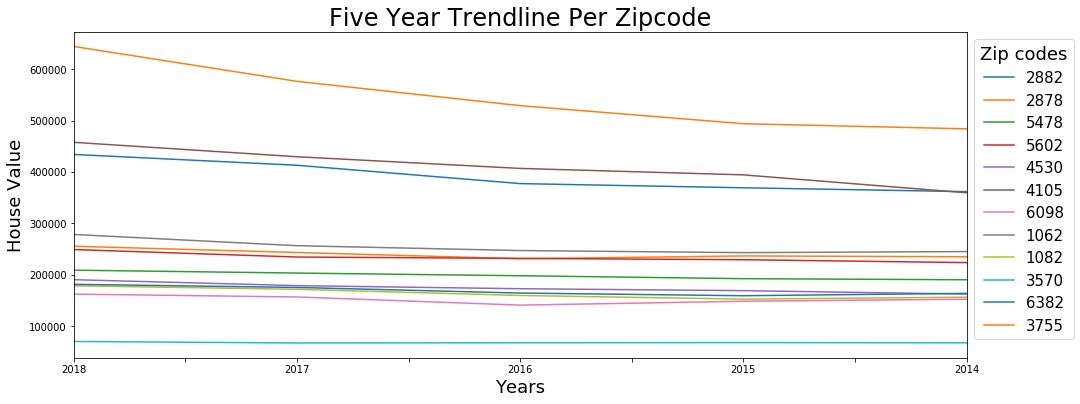

In [98]:
# Line graph showing five year trends for each zipcode
for index, row in ne_aves.iterrows():
    row[1:6].plot(kind = 'line', figsize=(16,6))
plt.title('Five Year Trendline Per Zipcode', size=24)
plt.xlabel('Years', size=18)
plt.ylabel('House Value', size=18)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1, title='Zip codes', 
          title_fontsize=18, fontsize=15)

Text(0, 0.5, 'Percantage')

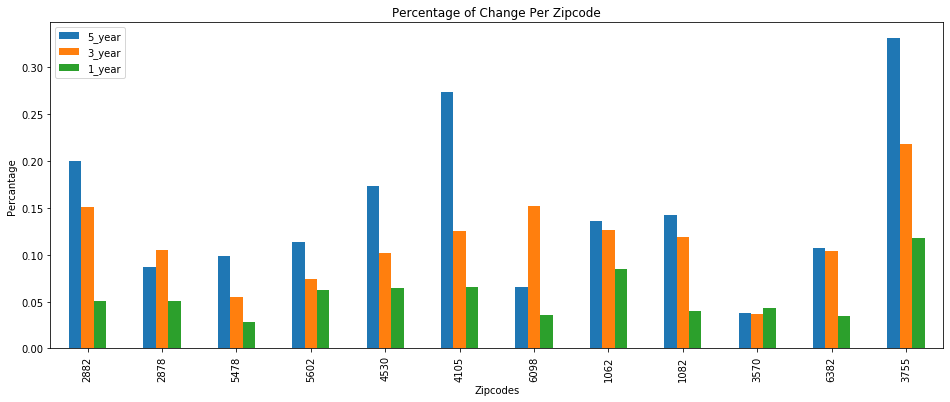

In [99]:
# Bar graph showing '5 year', '3 year', and  '1 year' percentage changes
ne_vil_averages.plot(x="Zipcode", y=['5_year', '3_year', '1_year'], kind="bar", figsize=(16,6))
plt.title('Percentage of Change Per Zipcode')
plt.xlabel('Zipcodes')
plt.ylabel('Percantage')

In [100]:
# According to the bar graph and percentages - top six zips
# 1062, 2882, 3755, 4105, 5602, 6382

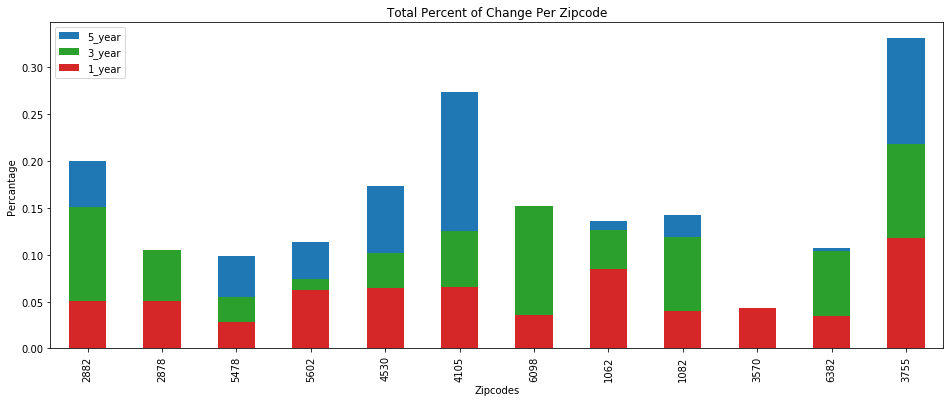

In [101]:
# Stacked bar graph showing total '5 year', '3 year', and  '1 year' percentage changes

ax = ne_vil_averages.plot(x="Zipcode", y='5_year', kind="bar", figsize=(16,6))
ne_vil_averages.plot(x="Zipcode", y='3_year', kind="bar", ax=ax, color="C2")
ne_vil_averages.plot(x="Zipcode", y='1_year', kind="bar", ax=ax, color="C3")
plt.title('Total Percent of Change Per Zipcode')
plt.xlabel('Zipcodes')
plt.ylabel('Percantage')
plt.show()

In [102]:
# Best over all - 1082, 2882, 3755, 4105, 5602, 6382

### Top six!

In [103]:
# Get my top six
ne_six = ne_vil_averages.copy()

In [104]:
# Drop the other six
ne_six.drop(ne_six[(ne_six.Zipcode == 1062) |
                  (ne_six.Zipcode == 2878) |
                  (ne_six.Zipcode == 3570) |
                  (ne_six.Zipcode == 4530) |
                  (ne_six.Zipcode == 5478) |
                  (ne_six.Zipcode == 6098)].index, inplace=True)

In [105]:
# Six for modeling!
ne_six

,Zipcode,State,2018,2017,2016,2015,2014,5_year,3_year,1_year
217,2882,RI,433991.666667,412908.333333,377183.333333,369075.000000,361550.000000,0.200364,0.150612,0.051061
318,5602,VT,248841.666667,234275.000000,231633.333333,229041.666667,223416.666667,0.113801,0.074291,0.062178
354,4105,ME,457558.333333,429500.000000,406783.333333,394225.000000,359308.333333,0.273442,0.124821,0.065328
371,1082,MA,178300.000000,171450.000000,159408.333333,152266.666667,156116.666667,0.142095,0.118511,0.039953
403,6382,CT,181150.000000,175050.000000,164133.333333,158933.333333,163541.666667,0.107669,0.103676,0.034847
475,3755,NH,644158.333333,576225.000000,528975.000000,493791.666667,483800.000000,0.331456,0.217748,0.117894


Text(0, 0.5, 'Percantage')

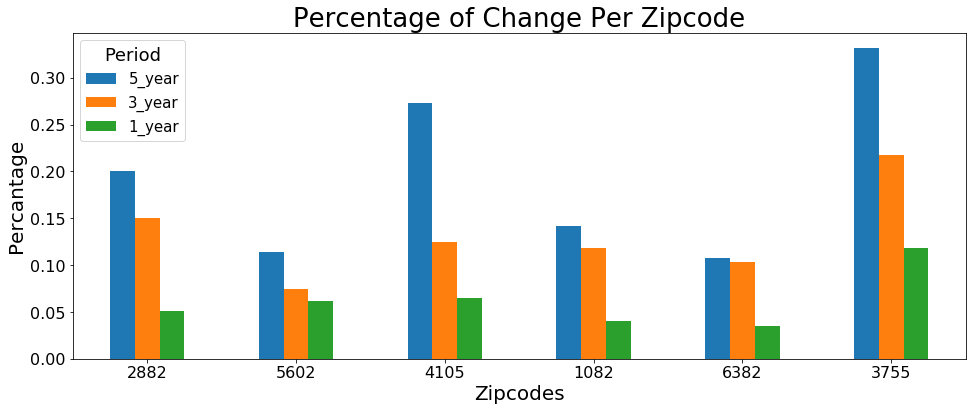

In [106]:
# Bar graph showing '5 year', '3 year', and  '1 year' percentage changes
ne_six.plot(x="Zipcode", y=['5_year', '3_year', '1_year'], kind="bar", 
            figsize=(16,6), fontsize=16)
plt.title('Percentage of Change Per Zipcode', size=26)
plt.legend(loc='upper left', title='Period',  title_fontsize=18, fontsize=15)
plt.xlabel('Zipcodes', size=20)
plt.xticks(rotation='horizontal')
plt.ylabel('Percantage', size=20)

### Back to the original data

In [107]:
# I need only the six rows in a new df
final_six = ne_villages.loc[(ne_villages['Zipcode'] == 1082) + 
                                (ne_villages['Zipcode'] == 2882) + 
                                (ne_villages['Zipcode'] == 3755) + 
                                (ne_villages['Zipcode'] == 4105) + 
                                (ne_villages['Zipcode'] == 5602) + 
                                (ne_villages['Zipcode'] == 6382)].sort_values(by='Zipcode')
final_six

/Users/whipxach/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/computation/expressions.py:194: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  op=op_str, alt_op=unsupported[op_str]


,Zipcode,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,population
371,1082,Ware,MA,Springfield,Hampshire,105300.0,104800.0,104100.0,103500.0,103000.0,...,174600,175400,176500,178000,179400,181100,182500,183300,183800,10322
217,2882,Narragansett,RI,Providence,Washington,145000.0,144700.0,144400.0,144100.0,143800.0,...,429900,430300,431400,433000,434500,435400,437100,442200,447900,14184
475,3755,Hanover,NH,Claremont,Grafton,210000.0,209500.0,208900.0,208400.0,208000.0,...,636800,641200,647700,650600,650100,650700,653700,656400,655900,10538
354,4105,Falmouth,ME,Portland,Cumberland,174100.0,174300.0,174400.0,174500.0,174400.0,...,449900,451100,454300,460500,465200,467000,470000,473100,472500,11158
318,5602,Montpelier,VT,Barre,Washington,98500.0,98200.0,97800.0,97500.0,97100.0,...,249200,251900,254000,254700,253100,249400,246400,244900,243500,11916
403,6382,Montville,CT,New London,New London,112800.0,112800.0,112800.0,112800.0,112800.0,...,179300,180600,181600,182400,182400,182600,183300,183900,183700,11947


In [108]:
# Drop unnecessary columns
final_six = final_six.drop(['City','State','Metro','CountyName', 'population'],
                           axis=1)
final_six

,Zipcode,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
371,1082,105300.0,104800.0,104100.0,103500.0,103000.0,102500.0,102000.0,101600.0,101300.0,...,174200,174600,175400,176500,178000,179400,181100,182500,183300,183800
217,2882,145000.0,144700.0,144400.0,144100.0,143800.0,143500.0,143400.0,143100.0,143000.0,...,429600,429900,430300,431400,433000,434500,435400,437100,442200,447900
475,3755,210000.0,209500.0,208900.0,208400.0,208000.0,207800.0,207700.0,207600.0,207600.0,...,634100,636800,641200,647700,650600,650100,650700,653700,656400,655900
354,4105,174100.0,174300.0,174400.0,174500.0,174400.0,174200.0,173900.0,173500.0,173200.0,...,447200,449900,451100,454300,460500,465200,467000,470000,473100,472500
318,5602,98500.0,98200.0,97800.0,97500.0,97100.0,96800.0,96400.0,96200.0,96100.0,...,247400,249200,251900,254000,254700,253100,249400,246400,244900,243500
403,6382,112800.0,112800.0,112800.0,112800.0,112800.0,112800.0,112800.0,112700.0,112800.0,...,178400,179300,180600,181600,182400,182400,182600,183300,183900,183700


In [109]:
final_six[['Zipcode','2018-04']].sort_values(by='Zipcode')

,Zipcode,2018-04
371,1082,183800
217,2882,447900
475,3755,655900
354,4105,472500
318,5602,243500
403,6382,183700


In [110]:
final_six[['Zipcode','2018-04']][1:2]

,Zipcode,2018-04
217,2882,447900


In [111]:
# Breaking them down one by one.

In [112]:
MA_1082 = ne_villages.loc[(ne_villages['Zipcode'] == 1082)]

In [113]:
MA_1082

,Zipcode,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,population
371,1082,Ware,MA,Springfield,Hampshire,105300.0,104800.0,104100.0,103500.0,103000.0,...,174600,175400,176500,178000,179400,181100,182500,183300,183800,10322


In [114]:
RI_2882 = ne_villages.loc[(ne_villages['Zipcode'] == 2882)]

In [115]:
RI_2882

,Zipcode,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,population
217,2882,Narragansett,RI,Providence,Washington,145000.0,144700.0,144400.0,144100.0,143800.0,...,429900,430300,431400,433000,434500,435400,437100,442200,447900,14184


In [116]:
NH_3755 = ne_villages.loc[(ne_villages['Zipcode'] == 3755)]

In [117]:
NH_3755

,Zipcode,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,population
475,3755,Hanover,NH,Claremont,Grafton,210000.0,209500.0,208900.0,208400.0,208000.0,...,636800,641200,647700,650600,650100,650700,653700,656400,655900,10538


## Reshape from Wide to Long Format

In [118]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['Zipcode', 'City', 'State', 'Metro', 'CountyName', 'population'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [119]:
Melted_1082 = melt_data(MA_1082)

In [120]:
Melted_1082.head()

,value
time,
1996-04-01,105300.0
1996-05-01,104800.0
1996-06-01,104100.0
1996-07-01,103500.0
1996-08-01,103000.0


In [121]:
Melted_2882 = melt_data(RI_2882)

In [122]:
Melted_2882.head()

,value
time,
1996-04-01,145000.0
1996-05-01,144700.0
1996-06-01,144400.0
1996-07-01,144100.0
1996-08-01,143800.0


In [123]:
Melted_3755 = melt_data(NH_3755)

In [124]:
Melted_3755.head()

,value
time,
1996-04-01,210000.0
1996-05-01,209500.0
1996-06-01,208900.0
1996-07-01,208400.0
1996-08-01,208000.0


In [125]:
Melted_3755.value[-1]

655900.0

# Visualization  ????????

In [126]:
# Just trying some things here...

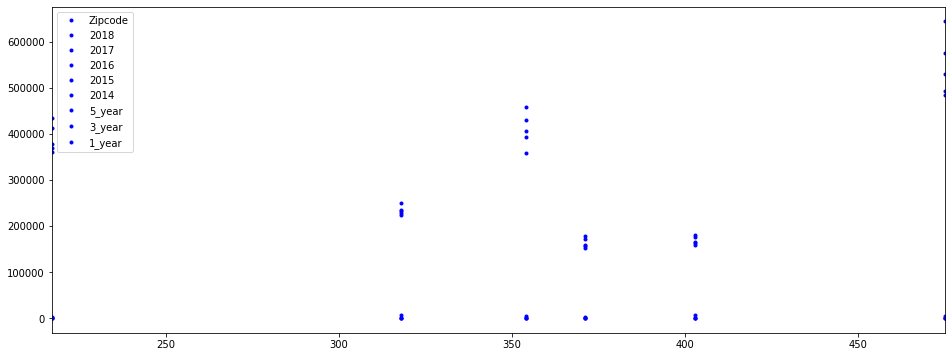

In [127]:
# Draw a line plot 
ne_six.plot(figsize = (16,6), style = 'b.')
plt.show()

In [128]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

#matplotlib.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

# Preparing the Model

### Auto Correlation and Partial Autocorrelation
These are plots that graphically summarize the strength of a relationship with an observation in a time series with observations at prior time steps.

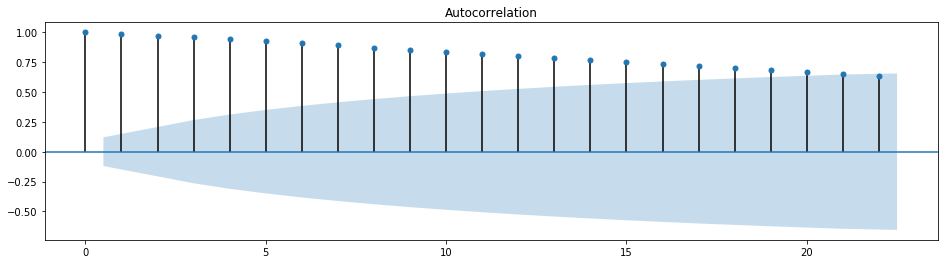

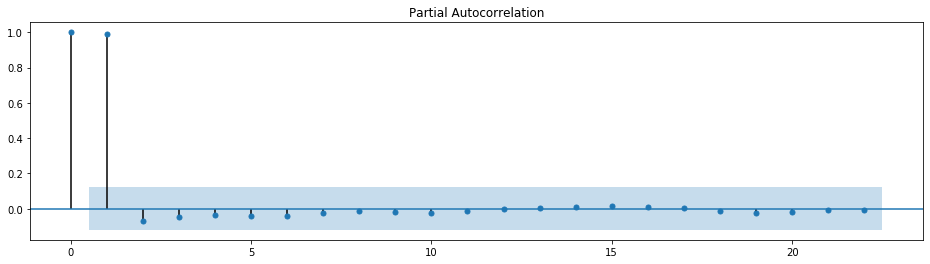

In [129]:
# Use 22 lags, one for each year (2018 - 1996)

fig, ax = plt.subplots(figsize=(16,4))
plot_acf(Melted_3755, ax=ax, lags=22);

fig, ax = plt.subplots(figsize=(16,4))
plot_pacf(Melted_3755, ax=ax, lags=22);

In [130]:
# Massachusettes 1082

In [131]:
Melted_1082.head()

,value
time,
1996-04-01,105300.0
1996-05-01,104800.0
1996-06-01,104100.0
1996-07-01,103500.0
1996-08-01,103000.0


In [132]:
Melted_3755.isnull().count()

value    265
dtype: int64

In [133]:
Melted_3755_MS = Melted_3755['value'].resample('MS').mean()

In [134]:
Melted_3755_MS = Melted_3755_MS.fillna(Melted_3755_MS.bfill())

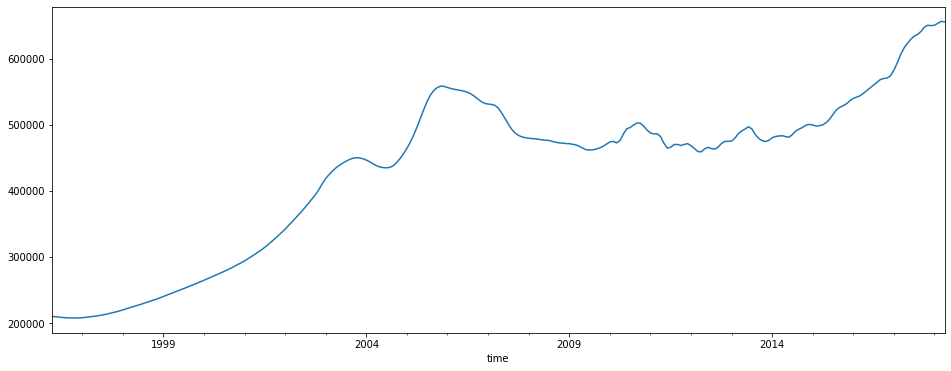

time
1996-04-01    210000.0
1996-05-01    209500.0
1996-06-01    208900.0
1996-07-01    208400.0
1996-08-01    208000.0
Freq: MS, Name: value, dtype: float64


In [135]:
# Plot the time series
Melted_3755_MS.plot(figsize=(16, 6))
plt.show()
print(Melted_3755_MS.head())

In [136]:
Melted_1082_MS = Melted_1082['value'].resample('MS').mean()

In [137]:
Melted_1082_MS = Melted_1082_MS.fillna(Melted_1082_MS.bfill())

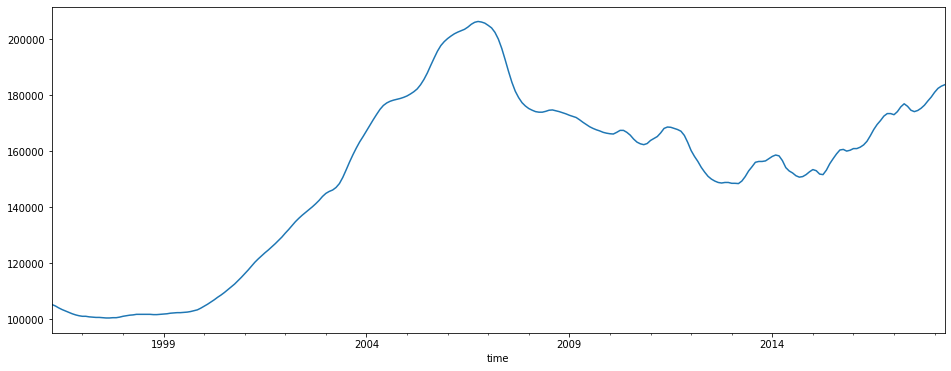

time
1996-04-01    105300.0
1996-05-01    104800.0
1996-06-01    104100.0
1996-07-01    103500.0
1996-08-01    103000.0
Freq: MS, Name: value, dtype: float64


In [138]:
# Plot the time series
Melted_1082_MS.plot(figsize=(16, 6))
plt.show()
print(Melted_1082_MS.head())

Housing prices peaked in early 2006, then started to decline reaching new lows in 2012. On December 30, 2008, the Case–Shiller home price index reported its largest price drop in its history.

In [139]:
# Rhode Island 2882

In [140]:
Melted_2882_MS = Melted_2882['value'].resample('MS').mean()

In [141]:
Melted_2882_MS = Melted_2882_MS.fillna(Melted_2882_MS.bfill())

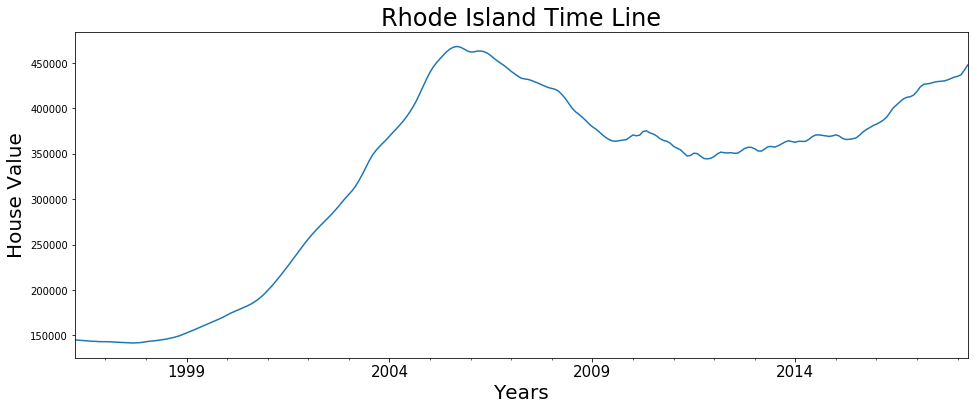

time
1996-04-01    145000.0
1996-05-01    144700.0
1996-06-01    144400.0
1996-07-01    144100.0
1996-08-01    143800.0
Freq: MS, Name: value, dtype: float64


In [142]:
Melted_2882_MS.plot(figsize=(16, 6))
plt.title('Rhode Island Time Line', size=24)
#plt.legend(loc='upper left', title='Rhode Island',  title_fontsize=18, fontsize=15)
plt.xlabel('Years', size=20)
plt.xticks(rotation='horizontal', size = 15)
plt.ylabel('House Value', size=20)
plt.show()
print(Melted_2882_MS.head())

# Modeling

### AIC (Akaike's Information Criterion) - Grid Search for Time Series!

Trend Elements

* p: Trend autoregression order.
* d: Trend difference order.
* q: Trend moving average order.

Seasonal Elements

* P: Seasonal autoregressive order.
* D: Seasonal difference order.
* Q: Seasonal moving average order.
* m: The number of time steps for a single seasonal period.

In [143]:
# Define the p, d and q parameters to take any value between 0 and 2

p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [144]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value

ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(Melted_3755_MS,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            #print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

/Users/whipxach/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/whipxach/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [145]:
#ARIMA (0, 1, 2) x (0, 2, 2, 12)12 : AIC Calculated = 3701

In [146]:
#ARIMA (2, 2, 2) x (1, 1, 2, 12)12 : AIC Calculated = 3683.98

In [147]:
#ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = ?

In [148]:
# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 1, 1)
pdqs    (0, 0, 1, 12)
aic           4339.07
Name: 57, dtype: object

In [149]:
ans_df.head()

,pdq,pdqs,aic
0,"(0, 0, 0)","(0, 0, 0, 12)",7622.847303
1,"(0, 0, 0)","(0, 0, 1, 12)",7121.785727
2,"(0, 0, 0)","(0, 1, 0, 12)",6066.232865
3,"(0, 0, 0)","(0, 1, 1, 12)",5790.165421
4,"(0, 0, 0)","(1, 0, 0, 12)",6033.431214


In [150]:
ans_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 3 columns):
pdq     64 non-null object
pdqs    64 non-null object
aic     64 non-null float64
dtypes: float64(1), object(2)
memory usage: 1.6+ KB


In [151]:
ans_df.loc[ans_df['aic'].idxmin()]['pdq']

(1, 1, 1)

In [152]:
ans_df.loc[ans_df['aic'].idxmin()]['pdqs']

(0, 0, 1, 12)

In [153]:
ans_df.loc[ans_df['aic'].idxmin()]['aic']

4339.07414165655

In [154]:
# Auto-Regressive Integrated Moving Average Model

## SARIMA or Seasonal ARIMA

In [155]:
# Plug the optimal parameter values into a new SARIMAX model
SARIMA_MODEL = sm.tsa.statespace.SARIMAX(Melted_3755_MS, 
                                        order=ans_df.loc[ans_df['aic'].idxmin()]['pdq'],
                                        seasonal_order=ans_df.loc[ans_df['aic'].idxmin()]['pdqs'], 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = SARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8731      0.037     23.315      0.000       0.800       0.946
ma.L1          0.6984      0.044     15.856      0.000       0.612       0.785
ma.S.L12      -0.3234      0.038     -8.418      0.000      -0.399      -0.248
sigma2      2.201e+06   1.48e+05     14.857      0.000    1.91e+06    2.49e+06


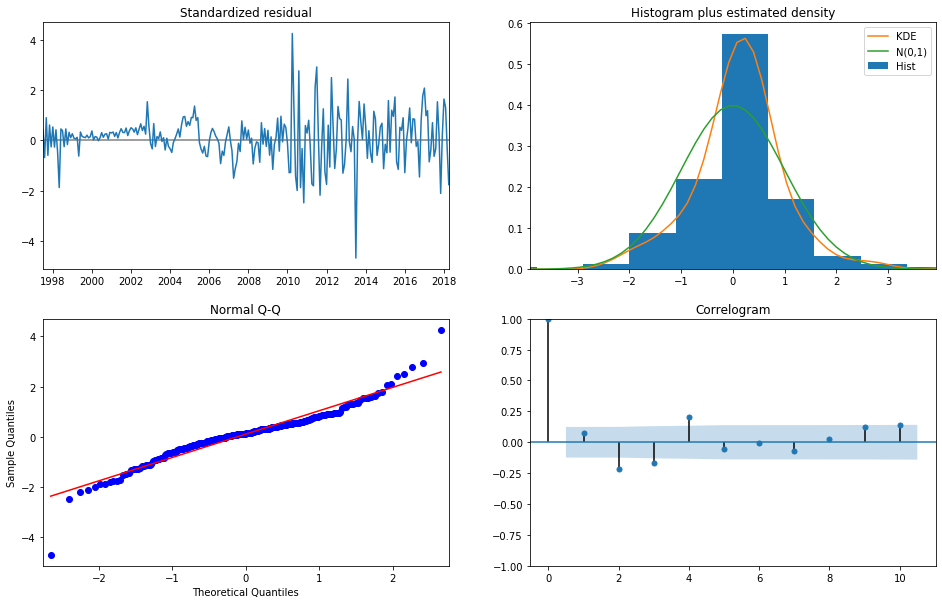

In [156]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(16, 10))
#plt.style.use('dark-background')
#plt.style.use('seaborn-bright')
#plt.style.use('bmh')
#plt.style.use('fivethirtyeight')
#plt.style.use('classic')
plt.show()

## Validating Results

### One-step Ahead Forecasting

In [157]:
# Get predictions starting from 2016-04-01 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2016-04-01'), dynamic=False)
pred_conf = pred.conf_int()

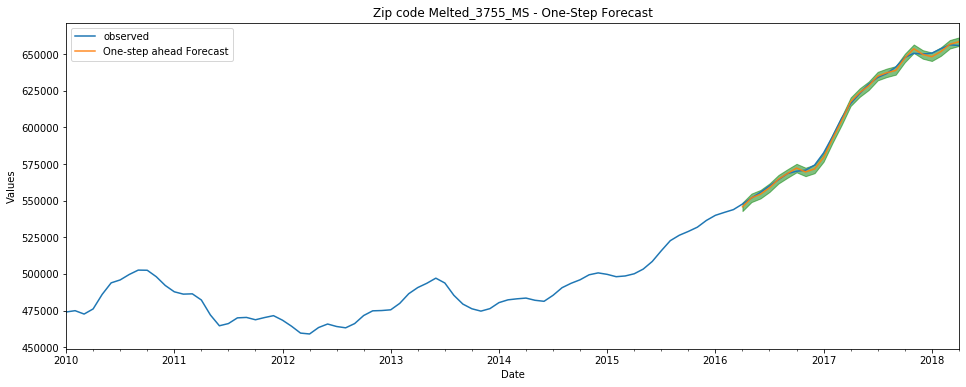

In [158]:
# Plot real vs predicted values along with confidence interval

rcParams['figure.figsize'] = (16, 6)

# Plot observed values
ax = Melted_3755_MS['2010':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_title('Zip code Melted_3755_MS - One-Step Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Values')
plt.legend()

plt.show()

In [159]:
# Get the real and predicted values
Melted_3755_MS_forecasted = pred.predicted_mean
Melted_3755_MS_truth = Melted_3755_MS['2016-04-01':]

# Compute the mean square error
mse = ((Melted_3755_MS_forecasted - Melted_3755_MS_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

# Compute the root mean square error
rmse = np.sqrt(mse)
print('The RMSE of our forecasts is {}'.format(round(rmse, 2)))


The Mean Squared Error of our forecasts is 2831160.97
The RMSE of our forecasts is 1682.61



A MSE this close to 0 indicates that the estimator is predicting observations of the parameter with perfect accuracy, which would be an ideal scenario but it is not typically possible.


### Dynamic Predictions

In [160]:
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output.get_prediction(start=pd.to_datetime('2016-04-01'), 
                                     dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

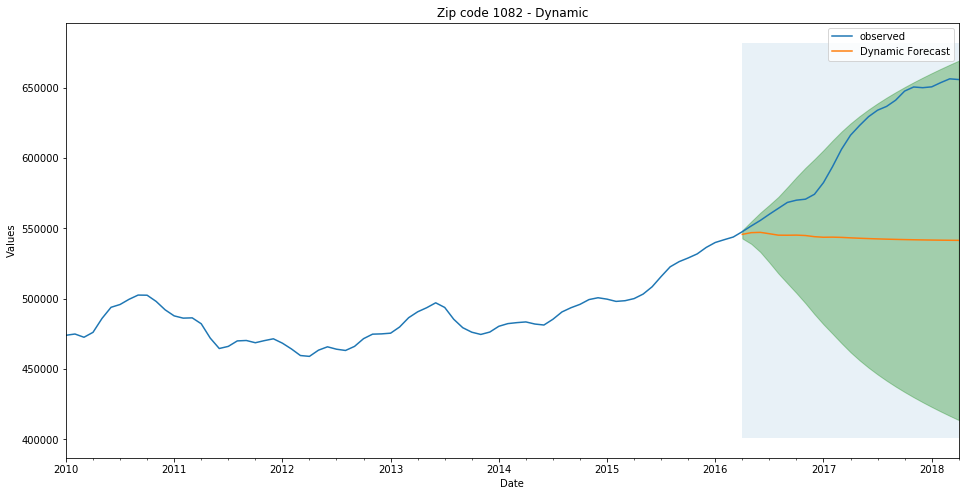

In [161]:
# Plot the dynamic forecast with confidence intervals.

ax = Melted_3755_MS['2010':].plot(label='observed', figsize=(16, 8))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2016-04-01'), 
                 Melted_3755_MS_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_title('Zip code 1082 - Dynamic')
ax.set_xlabel('Date')
ax.set_ylabel('Values')
plt.legend()
plt.show()

Once again, we quantify the predictive performance of our forecasts by computing the MSE.

In [162]:
# Extract the predicted and true values of our time series
Melted_3755_MS_forecasted = pred_dynamic.predicted_mean
Melted_3755_MS_truth = Melted_3755_MS['2016-04-01':]

# Compute the mean square error
mse = ((Melted_3755_MS_forecasted - Melted_3755_MS_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)), '\n')

# Compute the root mean square error
rmse = np.sqrt(mse)
print('The RMSE of our forecasts is {}'.format(round(rmse, 2)))


The Mean Squared Error of our forecasts is 5724066617.62 

The RMSE of our forecasts is 75657.56


**RMSE answers the question: "How similar, on average, are the numbers in list1 to list2?". The two lists must be the same size. I want to "wash out the noise between any two given elements, wash out the size of the data collected, and get a single number feel for change over time".

### Future Predictions

In [163]:
# Get forecast for future (72 steps = 6 years)
prediction = output.get_forecast(steps=72)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

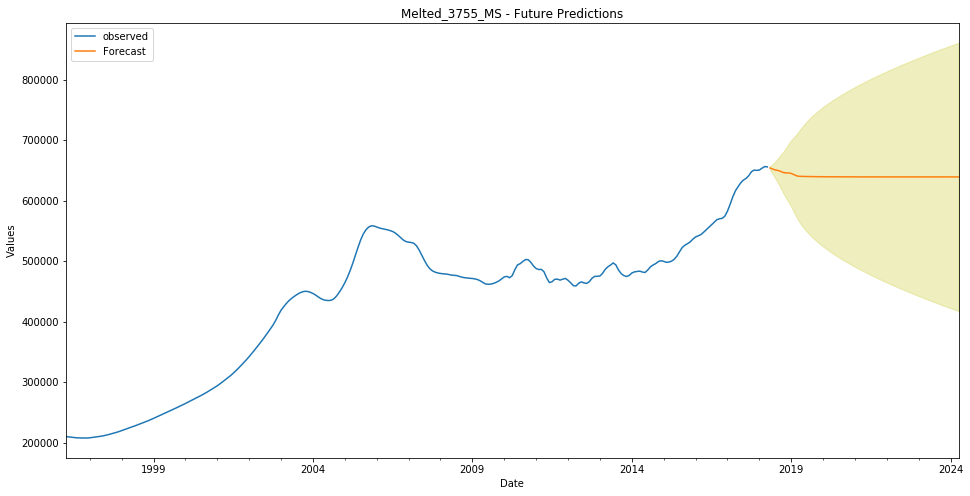

In [164]:
# Plot future predictions with confidence intervals
ax = Melted_3755_MS.plot(label='observed', figsize=(16, 8))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='y', alpha=0.25)
ax.set_title('Melted_3755_MS - Future Predictions')
ax.set_xlabel('Date')
ax.set_ylabel('Values')
plt.legend(loc='upper left')
plt.show()

In [165]:
pred_conf.head()

,lower value,upper value
2018-05-01,651202.441625,657017.450594
2018-06-01,644312.031151,660356.156180
2018-07-01,636856.704873,664843.854933
2018-08-01,629448.535915,670401.657427
2018-09-01,621231.969696,675745.280256


In [166]:
pred_conf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72 entries, 2018-05-01 to 2024-04-01
Freq: MS
Data columns (total 2 columns):
lower value    72 non-null float64
upper value    72 non-null float64
dtypes: float64(2)
memory usage: 1.7 KB


In [167]:
pred_conf.max()

lower value    651202.441625
upper value    861218.835321
dtype: float64

In [168]:
pred_conf.min()

lower value    417420.175721
upper value    657017.450594
dtype: float64

In [169]:
pred_conf.mean()

lower value    497253.831173
upper value    784121.749811
dtype: float64

In [170]:
pred_conf['mean value'] = pred_conf.apply(lambda row: (row['lower value'] + 
                                                       row['upper value'])/2, axis=1)

In [171]:
pred_conf.tail()

,lower value,upper value,mean value
2023-12-01,423758.708445,854880.712309,639319.710377
2024-01-01,422156.671728,856482.624906,639319.648317
2024-02-01,420566.409172,858072.779094,639319.594133
2024-03-01,418987.660603,859651.433048,639319.546825
2024-04-01,417420.175721,861218.835321,639319.505521


In [215]:
pred_conf['mean value'] = pred_conf.apply(lambda row: (row['lower value'] + 
                                                       row['upper value'])/2, 
                                              axis=1)

In [216]:
pred_conf['mean value'].mean()

640687.7904920512

In [213]:
mean_var = np.var(pred_conf['mean value'],ddof=1)
mean_var

10937194.98954072

In [210]:
pred_conf_mean = pred_conf['mean value'].mean()
pred_conf_mean

640687.7904920512

In [211]:
mean_var/pred_conf_mean

17.07102141144426

In [172]:
# Change in mean value
(639319.505521 - 654109.946109) / 654109.946109 * 100

-2.2611551278162856

In [173]:
pred_conf.index[60]

Timestamp('2023-05-01 00:00:00', freq='MS')

Text(0, 0.5, 'Value')

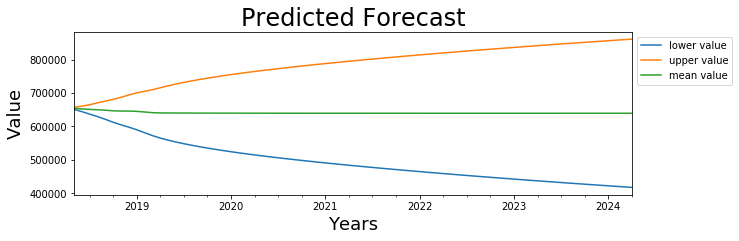

In [174]:
pred_conf.plot(figsize=(10,3))
plt.title('Predicted Forecast', size=24)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
plt.xlabel('Years', size=18)
plt.xticks(rotation='horizontal')
plt.ylabel('Value', size=18)

In [175]:
    print('The Five Year predictions are: ', '\n', (round(pred_conf.tail(1), 2)))

The Five Year predictions are:  
             lower value  upper value  mean value
2024-04-01    417420.18    861218.84   639319.51


In [176]:
start_pred = pred_conf['mean value'][0]
start_pred

654109.9461091948

In [177]:
end_pred = pred_conf['mean value'][60]
end_pred

639320.4858081375

In [178]:
change_pred = (end_pred - start_pred)/start_pred
print('Change in value:', round(change_pred,4)*100, '%')

Change in value: -2.26 %


In [179]:
final_change = final_six[['Zipcode','2018-04']].sort_values(by='Zipcode')

In [180]:
final_change.set_index('Zipcode', inplace=True)

In [181]:
final_change

,2018-04
Zipcode,
1082,183800
2882,447900
3755,655900
4105,472500
5602,243500
6382,183700


In [182]:
final_change.rename(columns = {'2018-04':'Current Value'}, inplace = True)

In [183]:
final_change

,Current Value
Zipcode,
1082,183800
2882,447900
3755,655900
4105,472500
5602,243500
6382,183700


In [184]:
final_change['Predicted Value'] = [208667, 610684, 639320, 583388, 250466, 203705]

In [185]:
final_change['Percent Change'] = ['13.36%','34.93%','-2.26%','23.88%','3.37%',"11.11%"]

In [186]:
final_change['RMSE'] = [652.46, 1189.54, 1682.61, 1496.72, 1002.6 , 492.69 ]

In [187]:
final_change['lower value'] = [117775.48, 355691.02, 437033.89, 348796.48, 179984.53, 120978.64]

In [188]:
final_change['upper value'] = [299559.42, 865677.64, 841607.45, 817979.55, 320949.13, 286433.35]

In [202]:
final_change['CV_UP_diff'] = final_change.apply(lambda row: round((row['upper value'] - 
                                                               row['Current Value'])/
                                                row['Current Value']*100,2), axis=1)

In [204]:
final_change['CV_LV_diff'] = final_change.apply(lambda row: round((row['Current Value'] - 
                                                               row['lower value'])/
                                                                  row['lower value']*100,2), axis=1)

In [227]:
final_change['NRMSE'] = final_change.apply(lambda row: (row['RMSE']/row['Predicted Value']*100)
                                                             , axis=1)

In [235]:
final_change['MaxMin RMSE'] = final_change.apply(lambda row: 
                                                 (row['RMSE']/(row['upper value'] - 
                                                               row['lower value'])*100), axis=1)

In [237]:
final_change['Predicted over RMSE'] = final_change.apply(lambda row: 
                                                 row['Predicted Value']/row['RMSE'], axis=1)

In [249]:
final_change['RMSE over Predicted'] = final_change.apply(lambda row: 
                                                 row['RMSE']/row['Predicted Value']*100, axis=1)

In [250]:
final_change

,Current Value,Predicted Value,Percent Change,RMSE,lower value,upper value,CV_UP_diff,CV_LV_diff,NRMSE,MaxMin RMSE,Predicted over RMSE,RMSE over Predicted
Zipcode,,,,,,,,,,,,
1082,183800,208667,13.36%,652.46,117775.48,299559.42,62.98,56.06,0.312680,0.358921,319.815774,0.312680
2882,447900,610684,34.93%,1189.54,355691.02,865677.64,93.27,25.92,0.194788,0.233249,513.378281,0.194788
3755,655900,639320,-2.26%,1682.61,437033.89,841607.45,28.31,50.08,0.263187,0.415897,379.957328,0.263187
4105,472500,583388,23.88%,1496.72,348796.48,817979.55,73.12,35.47,0.256557,0.319006,389.777647,0.256557
5602,243500,250466,3.37%,1002.60,179984.53,320949.13,31.81,35.29,0.400294,0.711242,249.816477,0.400294
6382,183700,203705,11.11%,492.69,120978.64,286433.35,55.92,51.84,0.241864,0.297779,413.454708,0.241864


In [ ]:
# def df_master_funct(df):
  #  melted = melt_data(df)
  #  corr_graphs(melted)
  #  output = run_model(melted)
  #  df_pred = get_predictions(melted, output)
  #  return df_pred

In [ ]:
# iterate over the df
# for row in df.iterrows():                 # for each row in the df
    # df_row = row.to_dataframe()           # turn row into a separate df
    # df_pred = master_function(df_row)     # run function with new df
    # all_preds = pd.concat(all_preds, df_pred)        # add the df to a new df
  ?  # all_preds.append(df_pred)

# or List Comprehension
    # df_preds = [ process_your_file(f) for f in files ]
    # result = pd.concat(df_preds)


# Interpreting Results

# Conclusion and Recommendation

In [ ]:
# MA 01082 The population density was 282.1 people per square mile (108.9/km²).

In [ ]:
# RI 02882 The population density was 1,156 people per square mile (446.4/km²).

In [ ]:
# NH 3755 The population density was 220 people per square mile (86/km2).

In [ ]:
# ME 4105 The population density was 380.7 inhabitants per square mile (147.0/km2).

In [ ]:
# VT 5602  The population density was 78.5 people per square mile (30.3/km2).

In [ ]:
# CT 6382 The population density was 441.4 people per square mile (170.4/km²). 